# fMRI Demo

## Introduction

Here we show how to load your BIDS-structured fMRI dataset into rsatoolbox. n14 2ses

![stimuli](demo_fmri_files/mur32_stims.png)

This library depends on *nibabel* for convenience functions to access MRI data, and is used separately in the demo as well, so start by installing nibabel (`pip install nibabel`).

Then run the following imports:

In [1]:
%matplotlib inline
from os.path import expanduser
from rsatoolbox.io.fmriprep import find_fmriprep_runs, make_design_matrix
from rsatoolbox.data.dataset import Dataset, merge_datasets
from rsatoolbox.vis import show_rdm
from rsatoolbox.rdm.calc import calc_rdm
import numpy, matplotlib.pyplot

Describe data dir

In [2]:
data_dir = expanduser('~/data/rsatoolbox/mur32')

Next we use a utility function to find the relevant preprocessed BOLD images:

In [3]:
runs = find_fmriprep_runs(data_dir, tasks=['main'])
len(runs)

54

Each run object carries the relevant data and metadata

In [4]:
run = runs[0]
run

<FmriprepRun [sub-08/ses-02/func/sub-08_ses-02_task-main_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz]>

In [5]:
dims = run.get_data().shape ## bold timeseries: x * y * z * volumes
n_vols = dims[-1]
dims

(65, 77, 55, 546)

In [6]:
tr = run.get_meta()['RepetitionTime'] ## TR in seconds
tr

2

In [7]:
run.get_events().sample(5) ## 5 random events

,onset,duration,trial_type,modality,identity,response_time,task,response_mapping
45,135.000,0.5,text_wheel,text,wheel,0.892,fixation,left-right
102,305.998,0.5,text_saddle,text,saddle,1.998,visual,left-right
302,905.989,0.5,image_bagel,image,bagel,1.530,fixation,right-left
99,296.994,0.5,image_wheel,image,wheel,2.156,visual,left-right
182,545.988,0.5,baseline,NaN,NaN,NaN,NaN,NaN


In [8]:
numpy.unique(run.get_parcellation())
it = run.get_parcellation() == 2009
it.sum()
## 2009	"ctx-rh-inferiortemporal"	#b42878

445

## Patterns

Next we want to establish Multi-Voxel Patterns from the timeseries, such that, for each stimulus presentation, we have one observation per voxel. The most common way to do this is with a General Linear Model, where each predictor in the model reflects one type of event, convolved with the haemodynamic response function (HRF). For the purposes of this demo we will use a very basic glm implementation in Python. For a guide on MVPA, see [Mur et al. 2009](https://doi.org/10.1093/scan/nsn044).

First we use a utility function which creates predictors from the events table and convolves them with the HRF. Note that we have 34 predictors, with a value for each volume in the BOLD timeseries. The smooth line that appears in the first ~70 timepoints is a side effect of the conditions being sorted according to their first occurrence.

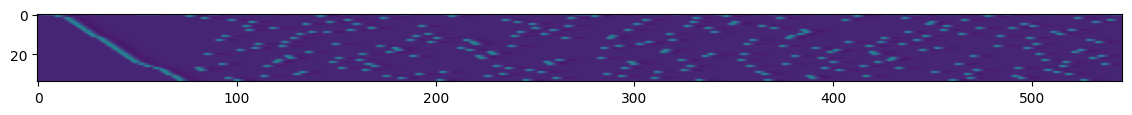

In [9]:
fig=matplotlib.pyplot.figure(figsize=(14,8))
dm = make_design_matrix(run.get_events(), tr, n_vols)
matplotlib.pyplot.imshow(dm.T)

Then we define our GLM function

In [10]:
def simple_glm(data, dm):
    data = data.reshape(-1, data.shape[-1])
    data = data / data.mean(axis=0)
    X = numpy.linalg.inv(dm.T @ dm) @ dm.T
    betas = X @ data.T
    return betas

When we apply this to the first run we get the following pattern array

In [11]:
patterns = simple_glm(run.get_data(), dm)
patterns.shape

(34, 275275)

We also need some metadata which identifies this run and its various dimensions

In [12]:
run.to_descriptors(collapse_by_trial_type=True)

{'descriptors': {'sub': '08', 'ses': '02', 'run': '02', 'task': 'main'},
 'obs_descriptors': {'trial_type': array(['baseline', 'instruction', 'image_clock', 'text_saddle',
         'image_ladder', 'text_table', 'text_helmet', 'text_brick',
         'image_bagel', 'image_brick', 'text_pedal', 'text_glove',
         'text_clock', 'text_ladder', 'image_glass', 'text_bagel',
         'image_saddle', 'image_pedal', 'text_candle', 'text_kettle',
         'image_helmet', 'text_spade', 'image_wheel', 'text_knife',
         'image_table', 'image_candle', 'image_glove', 'text_glass',
         'image_kettle', 'image_knife', 'image_spade', 'image_sponge',
         'text_wheel', 'text_sponge'], dtype=object)},
 'channel_descriptors': {'aparcaseg': array([0, 0, 0, ..., 0, 0, 0])}}

We can then combine the patterns and metadata to create an rsatoolbox `Dataset` object

In [13]:
Dataset(
    measurements=simple_glm(run.get_data(), dm),
    **run.to_descriptors(collapse_by_trial_type=True)
)

rsatoolbox.data.Dataset(
measurements = 
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
descriptors = 
{'sub': '08', 'ses': '02', 'run': '02', 'task': 'main'}
obs_descriptors = 
{'trial_type': array(['baseline', 'instruction', 'image_clock', 'text_saddle',
       'image_ladder', 'text_table', 'text_helmet', 'text_brick',
       'image_bagel', 'image_brick', 'text_pedal', 'text_glove',
       'text_clock', 'text_ladder', 'image_glass', 'text_bagel',
       'image_saddle', 'image_pedal', 'text_candle', 'text_kettle',
       'image_helmet', 'text_spade', 'image_wheel', 'text_knife',
       'image_table', 'image_candle', 'image_glove', 'text_glass',
       'image_kettle', 'image_knife', 'image_spade', 'image_sponge',
       'text_wheel', 'text_sponge'], dtype=object)}
channel_descriptors = 
{'aparcaseg': array([0, 0, 0, ..., 0, 0, 0])}

Let's repeat this for the other runs: (takes about 2m10s)

In [14]:
datasets = []
for run in runs:
    dm = make_design_matrix(run.get_events(), tr, n_vols)
    datasets.append(Dataset(
        measurements=simple_glm(run.get_data(), dm),
        **run.to_descriptors(collapse_by_trial_type=True)
    ))
len(datasets)

54

Then we combine the run-wise `Dataset` objects into one for the whole experiment (it's several gigabytes in size)

In [15]:
ds = merge_datasets(datasets)
print(f'{(ds.measurements.nbytes / 1024**3):.1f}GB')

3.7GB


## Calculate data RDMs

ROI

In [16]:
ds = ds.subset_channel('aparcaseg', 2009)


We will create one RDM for per subject, so that later we can test our hypothesis on the sample.
This splits the dataset into a list of `Dataset` objects:

In [17]:
subject_datasets = ds.split_obs(by='sub')
len(subject_datasets)

9

Then pass this list to `calc_rdm` to compute the crossvalidated mahalanobis or crossnobis dissimilarity:

In [18]:
data_rdms = calc_rdm(subject_datasets, method='crossnobis', descriptor='trial_type')

AssertionError: cv_descriptor generation failed:
different number of observations per pattern

Let's plot the participant RDMs.

In [ ]:
fig, _, _ = show_rdm(data_rdms)
matplotlib.pyplot.show()

## Model

![task design](demo_fmri_files/mur32_tasks.png)

In [ ]:
## model <- modality, indoor/outdoor, straight/curved